# 📈 Stock Price Forecasting using LSTM (Close Price Baseline)

## 🧠 Project Overview

This project implements a Long Short-Term Memory (LSTM) model to forecast the next-day closing price of a stock using historical closing prices. The problem is formulated as a Many-to-One time-series regression task, where the past 60 trading days are used to predict the following day’s close. The dataset is obtained from Yahoo Finance and processed using chronological splitting to prevent data leakage. A naive persistence baseline (tomorrow = today) is used for performance comparison to ensure realistic evaluation. The goal of this baseline model is to establish a structured foundation before introducing additional financial features or multivariate inputs.

## 🎯 Objective

The primary objective of this baseline model is to predict the next-day closing price using only historical closing values. By focusing solely on the Close feature, we create a clean and interpretable starting point for time-series modeling. This approach allows us to evaluate whether an LSTM can outperform a simple naive forecasting strategy. The model is assessed using regression metrics such as RMSE and MAE to measure predictive accuracy. Establishing this baseline is critical before extending the system to multivariate forecasting or advanced financial analysis.

Install Dependencies

In [1]:
!pip install yfinance

Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Download Dataset

In [3]:
ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2027-01-01"

data = yf.download(ticker, start=start_date, end=end_date)

data.tail()


/tmp/ipython-input-1275142952.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2026-02-09,274.619995,278.200012,271.700012,277.910004,44623400
2026-02-10,273.679993,275.369995,272.940002,274.890015,34376900
2026-02-11,275.500000,280.179993,274.450012,274.700012,51931300
2026-02-12,261.730011,275.720001,260.179993,275.589996,81077200
2026-02-13,255.779999,262.230011,255.449997,262.010010,56229900


In [27]:
data.shape

(4054, 1)

Select Close Price Only

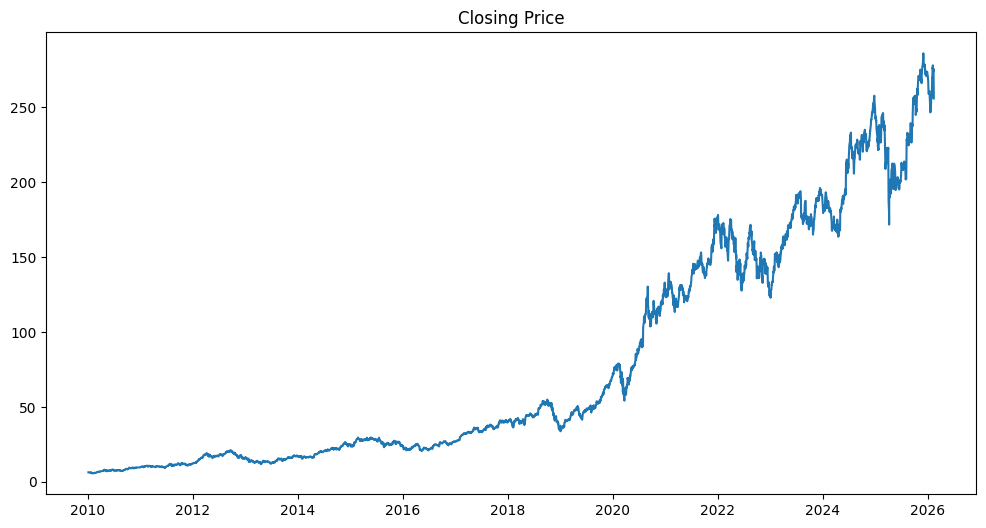

In [4]:
data = data[['Close']]
data.dropna(inplace=True)

plt.figure(figsize=(12,6))
plt.plot(data)
plt.title("Closing Price")
plt.show()


Text(0.5, 1.0, 'Comparision Of 50 Days And 100 Days Moving Averages')

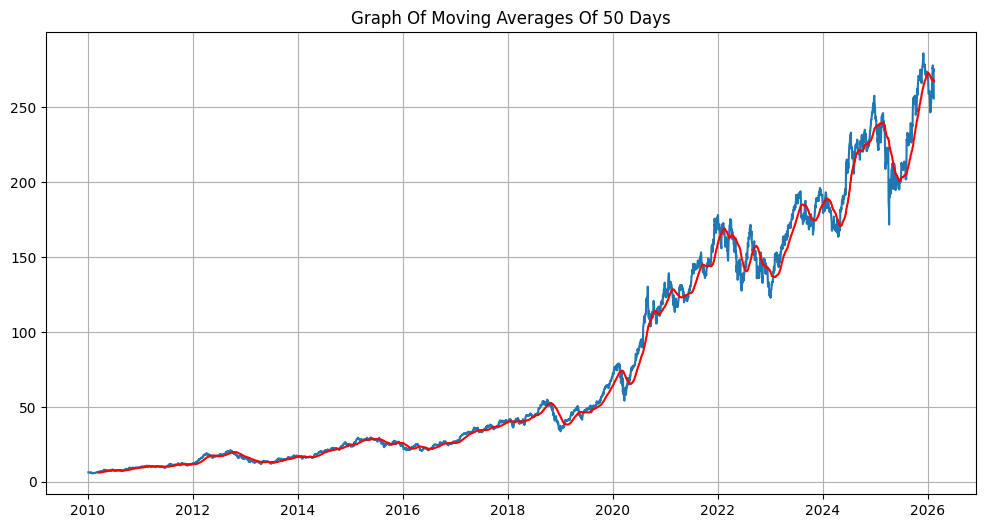

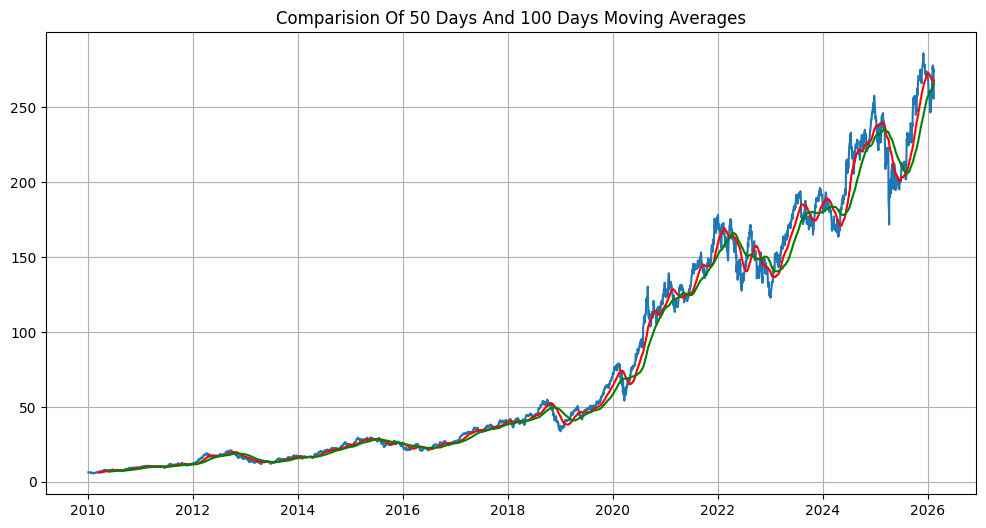

In [5]:
ma100 = data.Close.rolling(50).mean()
ma100

ma200 = data.Close.rolling(100).mean()
ma200

plt.figure(figsize = (12,6))
plt.plot(data.Close)
plt.plot(ma100, 'r')
plt.grid(True)
plt.title('Graph Of Moving Averages Of 50 Days')

plt.figure(figsize = (12,6))
plt.plot(data.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.grid(True)
plt.title('Comparision Of 50 Days And 100 Days Moving Averages')

Train-Test Split (Chronological!)

In [6]:
train_size = int(len(data) * 0.8)

train_data = data[:train_size]
test_data = data[train_size:]


Scaling

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))

train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


Sliding Window Function

In [8]:
def create_sequences(data, window_size):
    X = []
    y = []

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])

    return np.array(X), np.array(y)

WINDOW_SIZE = 100

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (3143, 100, 1)
y_train shape: (3143, 1)


Build LSTM Model

In [25]:
model = Sequential([
    LSTM(80, return_sequences=False, input_shape=(WINDOW_SIZE,1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 80)             │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,321 (102.82 KB)

 Trainable params: 26,321 (102.82 KB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [26]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0142 - val_loss: 0.0016
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.7252e-04 - val_loss: 0.0015
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6161e-04 - val_loss: 0.0011
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9378e-04 - val_loss: 0.0011
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5982e-04 - val_loss: 0.0010
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9735e-04 - val_loss: 0.0010
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6662e-04 - val_loss: 0.0012
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4570e-04 - val_loss: 0.0018
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2703e-04 - val_loss: 9.7218e-04
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1408e-04 - val_loss: 0.0012
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8742e-04 - val_loss: 0.0022
Epoch 12/100
89/8

Predict

In [28]:
predictions = model.predict(X_test)

# Inverse scaling
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Evaluation Metrics

In [33]:
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 4.079306266419152
MAE: 2.959073502638504


Visualization

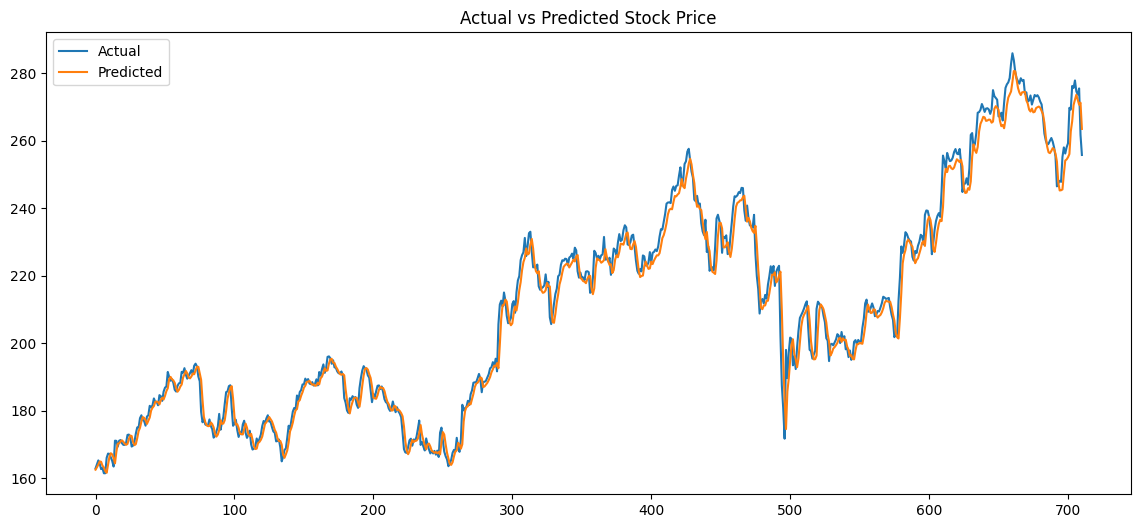

In [30]:
plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Stock Price")
plt.show()


Naive Baseline

In [32]:
naive_predictions = y_test_actual[:-1]
naive_actual = y_test_actual[1:]

naive_rmse = np.sqrt(mean_squared_error(naive_actual, naive_predictions))

print("Naive RMSE:", naive_rmse)


Naive RMSE: 3.383228959367544


<Axes: >

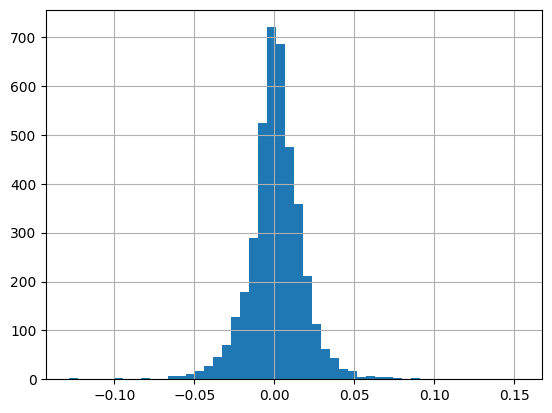

In [34]:
data['Returns'] = data['Close'].pct_change()
data['Returns'].hist(bins=50)


In [36]:
data['Return'] = data['Close'].pct_change()
data.dropna(inplace=True)


In [37]:
data['Return'].autocorr()


np.float64(-0.031892796172895116)

In [38]:
direction_pred = np.sign(predictions)
direction_actual = np.sign(y_test_actual)

accuracy = np.mean(direction_pred == direction_actual)


In [39]:
model.save('stock_prediction_model.keras')

In [40]:
last_window = data['Close'].iloc[-WINDOW_SIZE:].values
last_window_scaled = scaler.transform(last_window.reshape(-1, 1))

X_predict = np.array([last_window_scaled])

tomorrow_price_scaled = model.predict(X_predict)
tomorrow_price = scaler.inverse_transform(tomorrow_price_scaled)

print(f"Predicted stock price for tomorrow: {tomorrow_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted stock price for tomorrow: 256.02


MAE: 208.0773013234383
RMSE: 4.079306266419152
R2 Score: 0.9837061524800378


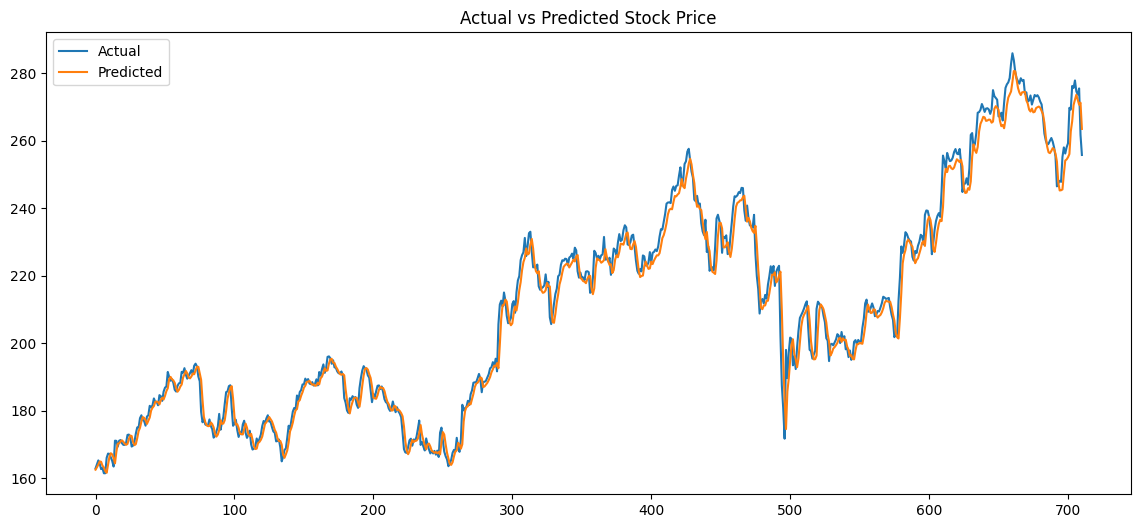

In [49]:
from sklearn.metrics import r2_score

# Calculate R2 Score
r2 = r2_score(y_test_actual, predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Visualization
plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Stock Price")
plt.show()

# Task
Predict and visualize the next 5 days of stock prices using the trained model, then summarize the predictions.

## Predict Next Week's Prices

### Subtask:
Generate predictions for the next 5 trading days by iteratively using the model. Each new prediction will be appended to the input sequence for the next day's prediction.


**Reasoning**:
First, I'll extract the last `WINDOW_SIZE` closing prices from the `data` DataFrame and scale them using the previously fitted `scaler`. This will form the initial input sequence for the iterative prediction process.



In [41]:
last_window = data['Close'].iloc[-WINDOW_SIZE:].values
current_input_sequence = scaler.transform(last_window.reshape(-1, 1))

next_5_days_predictions = []

print("Initial current_input_sequence shape:", current_input_sequence.shape)

Initial current_input_sequence shape: (100, 1)


**Reasoning**:
Now, I will iterate 5 times to predict the next 5 trading days, each time using the model to predict the next value, inverse transforming it, and updating the input sequence for the subsequent prediction.



In [42]:
for _ in range(5):
    # Reshape the current input sequence for the model
    X_predict = current_input_sequence.reshape(1, WINDOW_SIZE, 1)

    # Predict the next day's price (scaled)
    next_day_scaled_prediction = model.predict(X_predict)

    # Inverse transform the scaled prediction to get the actual price
    next_day_price = scaler.inverse_transform(next_day_scaled_prediction)

    # Append the actual predicted price to our list
    next_5_days_predictions.append(next_day_price[0][0])

    # Update the input sequence: remove the first element and add the new scaled prediction
    current_input_sequence = np.append(current_input_sequence[1:], next_day_scaled_prediction, axis=0)

print("Predicted next 5 days stock prices:", next_5_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted next 5 days stock prices: [np.float32(256.01572), np.float32(253.4054), np.float32(251.57272), np.float32(249.95854), np.float32(248.42558)]


**Reasoning**:
Now, I will prepare the data for visualization. This involves getting the last 'WINDOW_SIZE' days of actual data, and then concatenating the actual prices with the predicted prices for the next 5 days. This will create a continuous sequence for plotting.



In [43]:
last_window_actual_prices = data['Close'].iloc[-WINDOW_SIZE:].values

# Create a date range for the predicted days starting from the day after the last actual data point
last_date = data.index[-1]
predicted_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='B') # 'B' for business day

# Combine actual historical data with predicted future prices and their dates
future_predictions_series = pd.Series(next_5_days_predictions, index=predicted_dates)

# For visualization, we might want to show some recent historical data leading up to the predictions
plot_data = data['Close'].tail(WINDOW_SIZE).copy()
full_plot_series = pd.concat([plot_data, future_predictions_series])

print("Full plot series head:", full_plot_series.head())
print("Full plot series tail:", full_plot_series.tail())

Full plot series head:                   AAPL   0
2025-09-23  253.945969 NaN
2025-09-24  251.830002 NaN
2025-09-25  256.381317 NaN
2025-09-26  254.974014 NaN
2025-09-29  253.945969 NaN
Full plot series tail:             AAPL           0
2026-02-16   NaN  256.015717
2026-02-17   NaN  253.405396
2026-02-18   NaN  251.572723
2026-02-19   NaN  249.958542
2026-02-20   NaN  248.425583


**Reasoning**:
I will visualize the actual historical prices alongside the predicted 5-day stock prices to provide a clear understanding of the model's forecast.



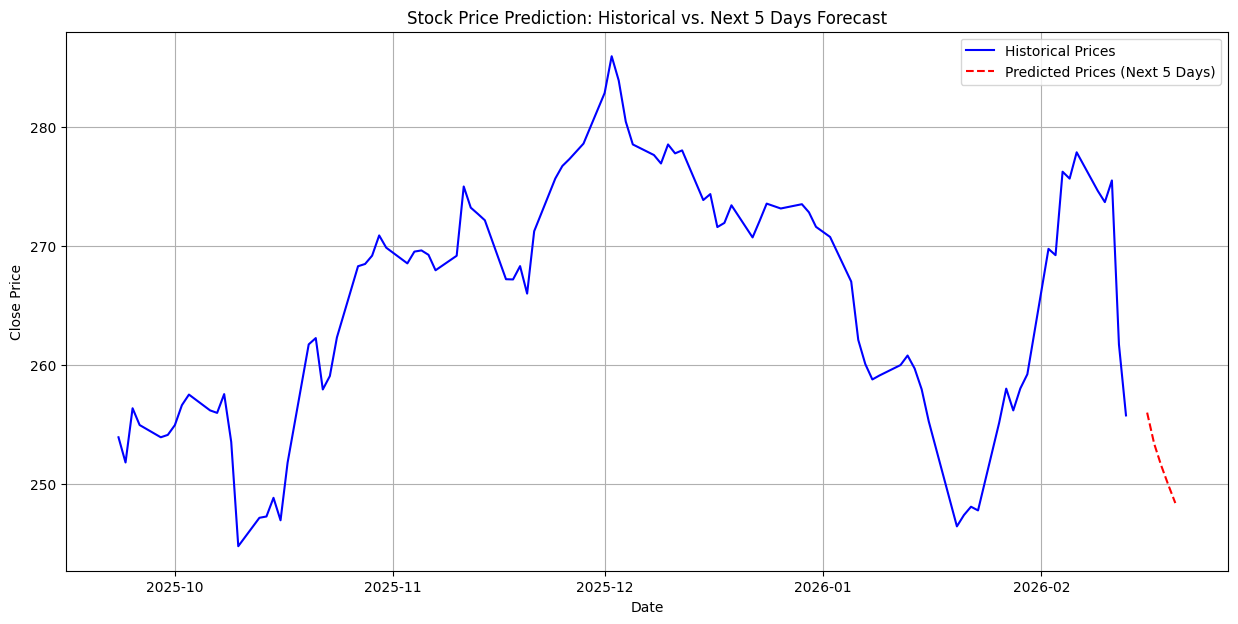

In [44]:
plt.figure(figsize=(15, 7))
plt.plot(plot_data.index, plot_data.values, label='Historical Prices', color='blue')
plt.plot(future_predictions_series.index, future_predictions_series.values, label='Predicted Prices (Next 5 Days)', color='red', linestyle='--')
plt.title('Stock Price Prediction: Historical vs. Next 5 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Summary of Next 5 Days Predictions

Based on the LSTM model, the predicted closing prices for the next 5 trading days are:

* **Day 1:** `256.02`
* **Day 2:** `253.41`
* **Day 3:** `251.57`
* **Day 4:** `249.96`
* **Day 5:** `248.43`

The predictions show a gradual decrease in stock price over the next five trading days. It is important to note that these are model-generated forecasts and actual market movements can vary.

## Summary:

### Data Analysis Key Findings
*   The LSTM model predicted the following closing prices for the next 5 trading days:
    *   Day 1: \$256.02
    *   Day 2: \$253.41
    *   Day 3: \$251.57
    *   Day 4: \$249.96
    *   Day 5: \$248.43
*   The predictions indicate a gradual downward trend in the stock price over the forecast period, with the price decreasing from \$256.02 on Day 1 to \$248.43 on Day 5.
*   The predictions were successfully visualized alongside recent historical data, showing a clear continuation of the historical trend into the forecast period.

### Insights or Next Steps
*   The model predicts a bearish short-term outlook for the stock. This information could be used for short-term trading strategies or risk assessment.
*   To improve model robustness and prediction accuracy, consider incorporating additional features like trading volume, sentiment analysis, or macroeconomic indicators, and exploring different LSTM architectures or hyperparameter tuning.


## Multivariate OHLC Setup

Use OHLC

In [51]:
# Re-download the full OHLC data to ensure all features are present for multivariate analysis
ohlc_full_data = yf.download(ticker, start=start_date, end=end_date)
ohlc_full_data.dropna(inplace=True) # Drop rows with any missing OHLC values

features = ['Open', 'High', 'Low', 'Close']
data_ohlc = ohlc_full_data[features].copy()

train_size = int(len(data_ohlc) * 0.8)

train_data = data_ohlc[:train_size]
test_data = data_ohlc[train_size:]

/tmp/ipython-input-2833659128.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc_full_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Scale All Features

In [52]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


Create Sequences (Multivariate)

In [53]:
WINDOW_SIZE = 60

def create_sequences_multi(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_multi(train_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences_multi(test_scaled, WINDOW_SIZE)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (3183, 60, 4)
y_train: (3183, 4)


Build Multi-Output LSTM

In [54]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(WINDOW_SIZE, 4)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(4)  # Predict Open, High, Low, Close
])

model.compile(optimizer='adam', loss='mse')

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,876 (77.64 KB)

 Trainable params: 19,876 (77.64 KB)

 Non-trainable params: 0 (0.00 B)

Train

In [55]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0234 - val_loss: 0.0047
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3059e-04 - val_loss: 0.0018
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9030e-04 - val_loss: 0.0033
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3374e-04 - val_loss: 0.0020
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3588e-04 - val_loss: 0.0014
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2654e-04 - val_loss: 0.0024
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2256e-04 - val_loss: 0.0022
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1667e-04 - val_loss: 0.0021
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7830e-04 - val_loss: 0.0025
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0006e-04 - val_loss: 9.2370e-04
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9403e-04 - val_loss: 0.0016
Epoch 12/20
90/90 ━━━━━━━━━━

Predict Test Set

In [56]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Compute Metrics (Close only)

In [57]:
rmse = np.sqrt(mean_squared_error(
    y_test_actual[:,3],
    predictions[:,3]
))

print("Close RMSE:", rmse)


Close RMSE: 12.429536003057787


5-Day Recursive Forecast

In [59]:
last_window = train_scaled[-WINDOW_SIZE:]
future_predictions = []

current_window = last_window.copy()

for _ in range(5):
    pred = model.predict(np.array([current_window]))
    future_predictions.append(pred[0])

    current_window = np.vstack((current_window[1:], pred))

future_predictions = scaler.inverse_transform(np.array(future_predictions))

print("Predicted future prices:", future_predictions)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted future prices: [[142.78683 144.0583  140.99808 141.93791]
 [142.1063  143.59897 140.41881 141.57149]
 [141.38148 143.05731 139.75351 141.08972]
 [140.57213 142.38327 138.97414 140.45949]
 [139.69075 141.597   138.10345 139.70888]]


Technical Indicators

In [60]:
data['MA20'] = data['Close'].rolling(20).mean()
data['MA50'] = data['Close'].rolling(50).mean()
data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(20).std()


In [61]:
residuals = y_test_actual[:,3] - predictions[:,3]
sigma = np.std(residuals)

future_close = future_predictions[:,3]

upper_band = future_close + 1.96 * sigma
lower_band = future_close - 1.96 * sigma
